In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import random_split, DataLoader, TensorDataset

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# define encoder
encoder_net = nn.Sequential(
    nn.Conv2d(3, 64, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(64, 128, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(128, 512, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2048, 10)
).to(device)

In [4]:
batch_size = 128

num_classes = 10

train_ds = torchvision.datasets.CIFAR10(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="data/", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size)

170499072it [00:36, 4692057.38it/s]                               


Extracting data/cifar-10-python.tar.gz to data/


In [5]:
model = encoder_net
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
model.train()

for epoch in range(10):
    print("Epoch: ", epoch)
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(128, 512, kernel_size=(4, 4), stride=(2, 2))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=10, bias=True)
)

In [7]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import MMDDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
from alibi_detect.cd.pytorch import preprocess_drift

from torchvision.datasets import CIFAR10

from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T

torch.manual_seed(42)

In [11]:
test_transforms = T.Compose([
    T.ToTensor(),
    # this is not required as i trained without any normalization ;)
    # but never do this in production
    # T.Normalize(
    #     mean=[0.491, 0.482, 0.446],
    #     std=[0.247, 0.243, 0.261]
    # )
])

In [12]:
cifar10_test_ds = CIFAR10("data/", train=False, download=True, transform=test_transforms)

Files already downloaded and verified


In [13]:
len(cifar10_test_ds), len(cifar10_test_ds)

(10000, 10000)

In [14]:
test_ref, test_ref_h0 = torch.utils.data.random_split(cifar10_test_ds, (5_000, 5_000), )

In [15]:
test_ref_data, test_ref_data_h0 = next(iter(DataLoader(test_ref, batch_size=5_000, shuffle=False))), next(iter(DataLoader(test_ref_h0, batch_size=5_000, shuffle=False)))

In [16]:
test_ref_data[0].shape, test_ref_data[1].shape

(torch.Size([5000, 3, 32, 32]), torch.Size([5000]))

In [17]:
test_ref_data_h0[0].shape, test_ref_data_h0[1].shape

(torch.Size([5000, 3, 32, 32]), torch.Size([5000]))

In [18]:
classes, counts_ref = np.unique(test_ref_data[1], return_counts=True)

In [19]:
n_test = test_ref_data_h0[0].shape[0]
classes, counts_ref = np.unique(test_ref_data[1], return_counts=True)
counts_h0 = np.unique(test_ref_data_h0[1], return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     512 488
1     524 476
2     464 536
3     488 512
4     529 471
5     489 511
6     505 495
7     506 494
8     483 517
9     500 500


We are using the trained model to detect drifts !

In [20]:
preprocess_fn = partial(preprocess_drift, model=encoder_net, device=device, batch_size=512)

Maximum Mean Discrepancy

In [25]:
test_ref_data[0].shape

torch.Size([5000, 3, 32, 32])

In [21]:
cd = MMDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

In [19]:
import albumentations as A
import matplotlib.pyplot as plt

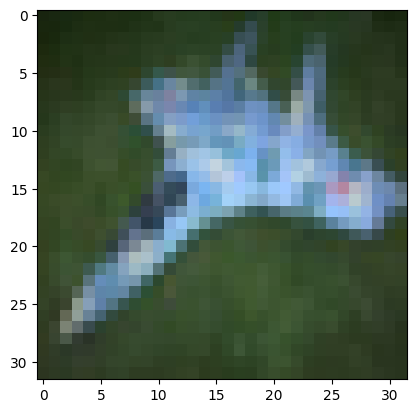

In [20]:
plt.imshow(
    torch.tensor(test_ref_data_h0[0][10].numpy()).permute(1, 2, 0)
)
plt.show()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
torch.argmax(encoder_net(test_ref_data_h0[0][10][None, ...].to(device)), dim=-1)

tensor([1], device='cuda:0')

The results seem to be correct

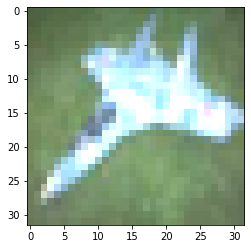

In [ ]:
perturb = A.RandomBrightnessContrast(
    brightness_limit=1.5,
    contrast_limit=0.9,
    p=1.0
)

perturbed_image = torch.tensor(
    perturb(
        image=test_ref_data_h0[0][10].numpy(),
    )['image']
)

plt.imshow(
    perturbed_image.permute(1, 2, 0)
)
plt.show()

In [ ]:
torch.argmax(encoder_net(perturbed_image[None, ...].to(device)), dim=-1)

tensor([7], device='cuda:0')

Look the prediction changed !

Let's try the drift detection on the reference data

In [ ]:
cd.predict(test_ref_data_h0[0][:100])

{'data': {'is_drift': 0,
  'distance': -0.00018918514251708984,
  'p_val': 0.4000000059604645,
  'threshold': 0.05,
  'distance_threshold': array(0.00683397, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

In [ ]:
perturbed_images = []

for idx in range(100):
    perturbed_image = torch.tensor(
        perturb(
            image=test_ref_data_h0[0][idx].numpy(),
        )['image']
    )

    perturbed_images.append(perturbed_image)

perturbed_images = torch.stack(perturbed_images)

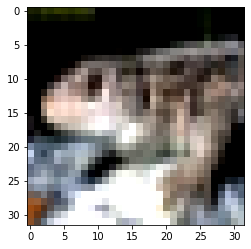

In [ ]:
plt.imshow(perturbed_images[0].permute(1, 2, 0))

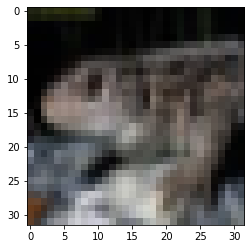

In [ ]:
plt.imshow(test_ref_data_h0[0][0].permute(1, 2, 0))

Now let's try on the perturbed data

In [ ]:
cd.predict(perturbed_images[:100])

{'data': {'is_drift': 1,
  'distance': 0.11001944541931152,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.00444746, dtype=float32)},
 'meta': {'name': 'MMDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

## LSDD Drift (Least-Squares Density Difference)

In [ ]:
from alibi_detect.cd import LSDDDrift

In [ ]:
cd = LSDDDrift(test_ref_data[0], backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)

In [ ]:
cd.predict(perturbed_images[:100])

{'data': {'is_drift': 1,
  'distance': 0.3328023850917816,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': array(0.03324323, dtype=float32)},
 'meta': {'name': 'LSDDDriftTorch',
  'online': False,
  'data_type': None,
  'version': '0.10.4',
  'detector_type': 'drift',
  'backend': 'pytorch'}}

## Kernel MMD (Torch Drift)

In [ ]:
import torchdrift
import sklearn

Sometimes you are not allowed to make changes in the model, so here we can use a resnet model trained on imagenet !

In [ ]:
feature_extractor = torchvision.models.resnet18(pretrained=True)
feature_extractor.fc = torch.nn.Identity()

feature_extractor = feature_extractor.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
drift_detector = torchdrift.detectors.KernelMMDDriftDetector()

In [ ]:
cifar10_train_ds = CIFAR10(".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified


In [ ]:
cifar10_train_dl = DataLoader(cifar10_train_ds, batch_size=128, shuffle=False)

In [ ]:
torchdrift.utils.fit(cifar10_train_dl, feature_extractor, drift_detector)

100%|██████████| 79/79 [00:01<00:00, 54.01it/s]


In [ ]:
drift_detection_model = torch.nn.Sequential(
    feature_extractor,
    drift_detector
).to(device)

In [ ]:
perturbed_images.shape

torch.Size([100, 3, 32, 32])

Perturbed Data

In [ ]:
with torch.no_grad():
    # features = feature_extractor(perturbed_images.to(device))
    # score = drift_detector(features)
    score = drift_detection_model(perturbed_images.to(device))
    # p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.1963, device='cuda:0'), tensor(0.0350, device='cuda:0'))

P-Value is 0 ! that means a drift !

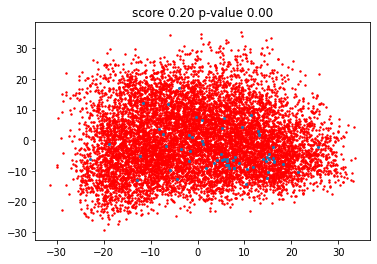

In [ ]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()

Reference Data

In [ ]:
with torch.no_grad():
    features = feature_extractor(test_ref_data_h0[0][:100].to(device))
    score = drift_detector(features)
    p_val = drift_detector.compute_p_value(features)
score, p_val

(tensor(0.0123, device='cuda:0'), tensor(0.0350, device='cuda:0'))

P-Value is 0.03, not a drift

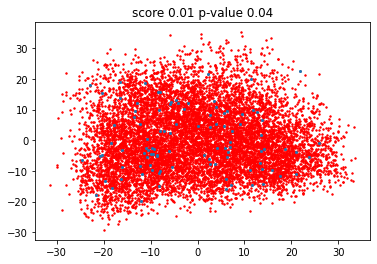

In [ ]:
N_base = drift_detector.base_outputs.size(0)
mapper = sklearn.manifold.Isomap(n_components=2)
base_embedded = mapper.fit_transform(drift_detector.base_outputs.cpu())
features_embedded = mapper.transform(features.cpu().detach().numpy())
plt.scatter(base_embedded[:, 0], base_embedded[:, 1], s=2, c='r')
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], s=4)
plt.title(f'score {score:.2f} p-value {p_val:.2f}')
plt.show()